In [1]:
import numpy as np
import scipy.signal as signal
import pandas as pd
from wfdb import processing
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features, get_frequency_domain_features

In [2]:
class ECGSignal():
    def __init__(self, ecg_signal, Fs=1000, lowcut=0.3, highcut=60, resample_fs=128):
        self.ecg_signal = ecg_signal
        self.Fs = Fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.resample_fs = resample_fs

        self.filtered_ecg_signal = self.apply_filter_to_signal()
        self.resampled_ecg_signal = signal.resample(self.filtered_ecg_signal, (len(self.ecg_signal) // self.Fs) * self.resample_fs)

        self.conf = processing.XQRS.Conf(ref_period=0.4)
        self.xqrs = processing.XQRS(sig=ecg_signal, fs=Fs, conf=self.conf)
        self.xqrs.detect(learn=False)
        peaks = self.xqrs.qrs_inds / Fs
        self.RRI = np.diff(peaks)

    def get_rri(self):
        return self.RRI

    def butter_bandpass(self, order=4):
    # to gain paramaters of butterworth bandpass filter
        nyq = 0.5 * self.Fs
        low = self.lowcut / nyq
        high = self.highcut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a

    def apply_filter_to_signal(self, order=4):
    # apply butterworth bandpass filter to the signal
        b, a = self.butter_bandpass(order)
        filtered = signal.filtfilt(b, a, self.ecg_signal)
        return filtered

In [3]:
def csv_to_signal(filepath, header=None, skiprows=13):
    ecg_df = pd.read_table(filepath, header=header, skiprows=skiprows)[0]
    ecg_signal = ecg_df.values

    return ecg_signal

In [4]:
def preprocess_hrvanalysis(rri, low_rri=300, high_rri=2000, interpolation_method="linear", remove_method="malik"):
    rri_int = np.array(list(map(int, rri * 1000)))

    # This remove outliers from signal
    rr_intervals_without_outliers = remove_outliers(rr_intervals=rri_int,                                                     low_rri=low_rri, high_rri=high_rri)

    # This replace outliers nan values with linear interpolation
    interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method=interpolation_method)

    # This remove ectopic beats from signal
    nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method=remove_method)
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

    return rri_int, np.array(interpolated_rr_intervals), np.array(nn_intervals_list), np.array(interpolated_rr_intervals)

In [5]:
def calc_hrv_features(nn_intervals):
    time_domain_features = get_time_domain_features(nn_intervals)
    frequency_features = get_frequency_domain_features(nn_intervals)

    return time_domain_features, frequency_features

In [7]:
filepath = '../data/WAV_00000010.txt'

Fs = 1000  # [Hz]

ecg_signal = ECGSignal(csv_to_signal(filepath))
rri = ecg_signal.get_rri()

rri_int, interpolated_rr_intervals, nn_intervals_list, interpolated_nn_intervals = preprocess_hrvanalysis(rri)

Initializing using default parameters
Running QRS detection...
QRS detection complete.
0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with malik rule.


In [8]:
window = 20 * 1000
step = 5 * 1000
cumsum = np.nancumsum(interpolated_nn_intervals)
window_num = (int(cumsum[-1]) - window) // step + 1
timedomain = []
frequency = []

for w in range(window_num):
    start = w * step
    end = window + w * step
    windowed_rri = interpolated_nn_intervals[(start < cumsum) & (cumsum < end)]
    time_domain_features, frequency_features = calc_hrv_features(windowed_rri)
    timedomain.append(time_domain_features)
    frequency.append(frequency_features)


/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 74, using nperseg = 74
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 75, using nperseg = 75
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 79, using nperseg = 79
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 76, using nperseg = 76
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: npe

In [9]:
timedomain_df = pd.DataFrame([])
frequency_df = pd.DataFrame([])
timedomain_df = pd.concat([timedomain_df, pd.DataFrame.from_dict(timedomain)])
frequency_df = pd.concat([frequency_df, pd.DataFrame.from_dict(frequency)])


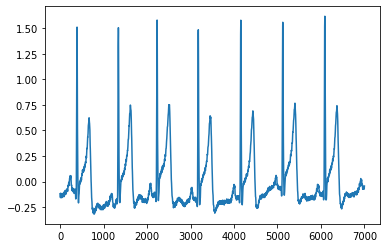

In [10]:
plt.plot(ecg_signal.ecg_signal[30*Fs:37*Fs])

In [11]:
timedomain_df.head()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr
0,922.666667,23.405840,33.229354,2,10.000000,11,55.000000,33.283630,925.0,87,0.036073,0.025368,65.069459,69.204152,62.893082,1.639045
1,931.285714,26.942797,34.984997,2,10.000000,12,60.000000,35.273219,934.0,107,0.037876,0.028931,64.479543,69.204152,61.601643,1.860166
2,938.727273,29.738834,39.302998,5,23.809524,11,52.380952,39.303459,944.0,124,0.041869,0.031680,63.978603,69.204152,60.544904,2.013918
3,948.809524,33.117396,39.897870,5,25.000000,11,55.000000,39.929939,952.0,124,0.042084,0.034904,63.313112,69.204152,60.544904,2.232067
4,955.428571,27.706626,33.573650,3,15.000000,9,45.000000,33.585711,965.0,101,0.035153,0.028999,62.850823,67.415730,60.544904,1.830461


In [12]:
frequency_df

,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
0,58.736601,43.072704,1.363662,57.692763,42.307237,116.218934,14.409630
1,29.096582,276.451774,0.105250,9.522742,90.477258,310.093643,4.545287
2,201.333424,277.524150,0.725463,42.044532,57.955468,523.858197,45.000623
3,412.549437,189.034522,2.182403,68.577200,31.422800,618.032536,16.448578
4,403.843217,200.910581,2.010064,66.778120,33.221880,617.521808,12.768010
...,...,...,...,...,...,...,...
165,314.609642,256.522980,1.226438,55.085217,44.914783,717.630406,146.497783
166,42.569665,323.889955,0.131432,11.616468,88.383532,376.878272,10.418653
167,228.738724,895.593740,0.255405,20.344403,79.655597,1144.896195,20.563731
168,391.669421,1210.228519,0.323633,24.450336,75.549664,1674.159849,72.261909


<AxesSubplot:>

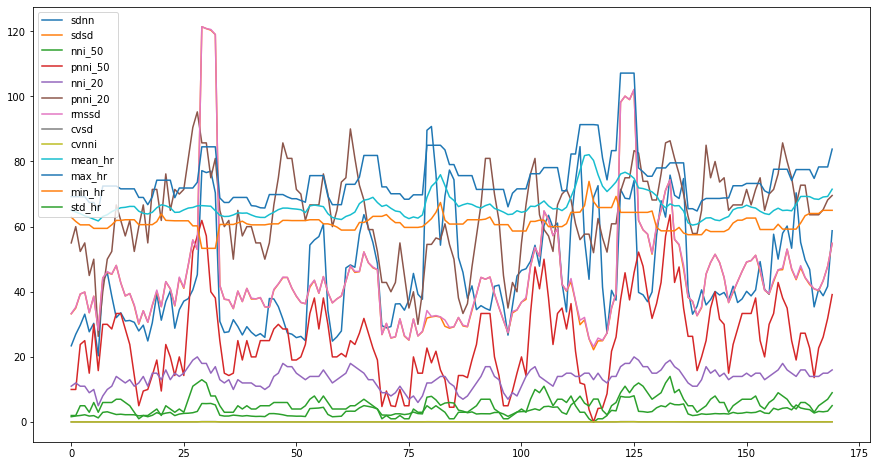

In [13]:
vec = list(timedomain_df.columns)
rm = ['range_nni', 'median_nni', 'mean_nni']
ind = [f for f in vec if f not in rm]

timedomain_df[ind].plot(legend=True, figsize=(15, 8))


<AxesSubplot:>

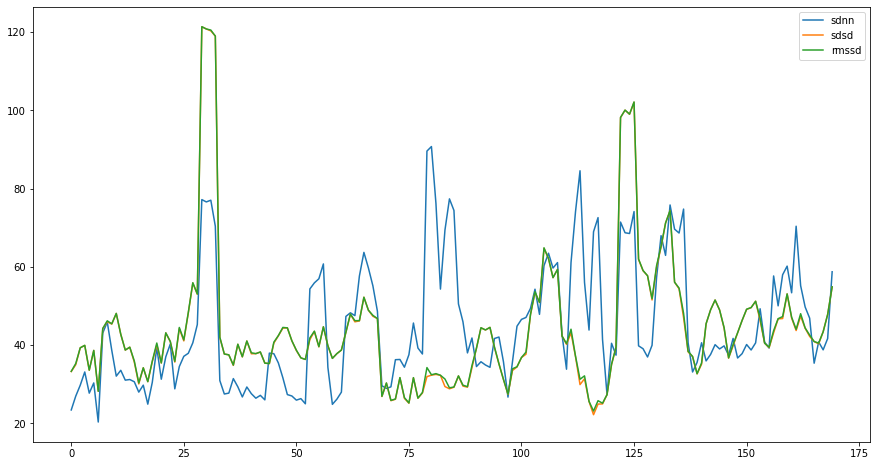

In [14]:
timedomain_df[['sdnn', 'sdsd', 'rmssd']].plot(legend=True, figsize=(15, 8))

<AxesSubplot:>

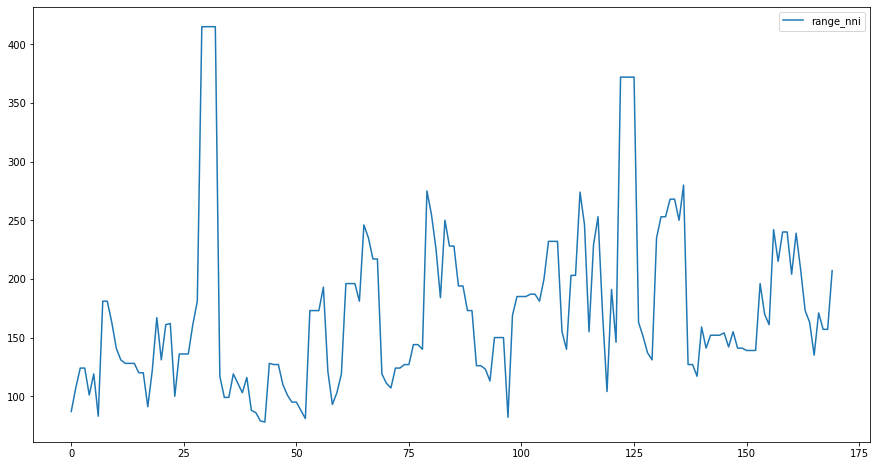

In [15]:
timedomain_df['range_nni'].plot(legend=True, figsize=(15, 8))

<AxesSubplot:>

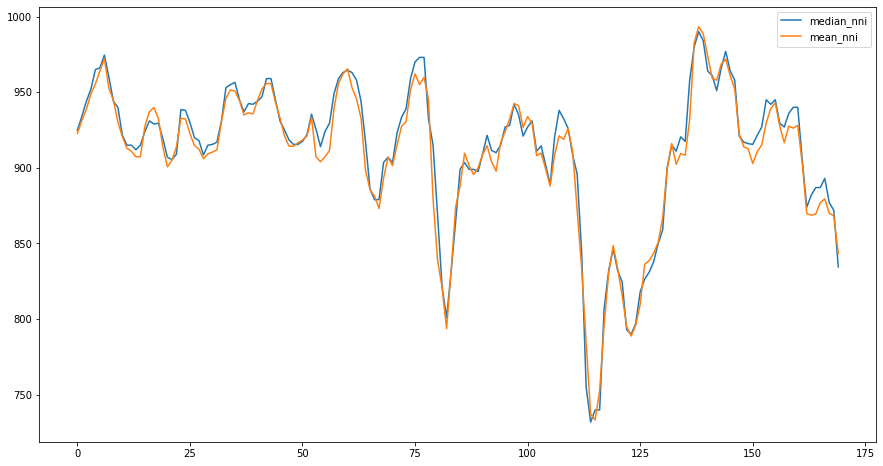

In [16]:
timedomain_df[['median_nni', 'mean_nni']].plot(legend=True, figsize=(15, 8))

<AxesSubplot:>

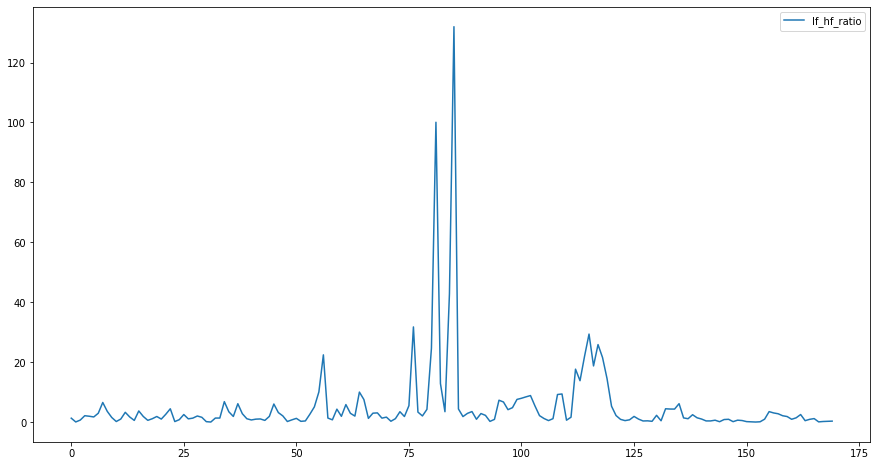

In [17]:
frequency_df['lf_hf_ratio'].plot(legend=True, figsize=(15, 8))


<AxesSubplot:>

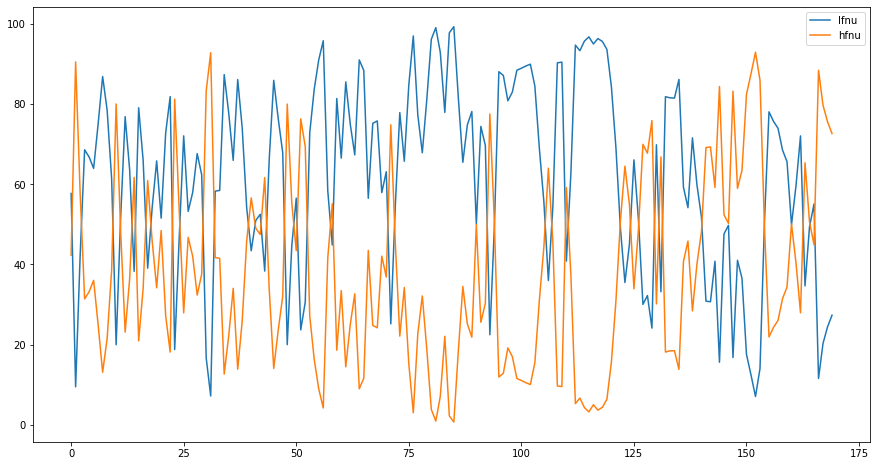

In [18]:
frequency_df[['lfnu', 'hfnu']].plot(legend=True, figsize=(15, 8))


<AxesSubplot:>

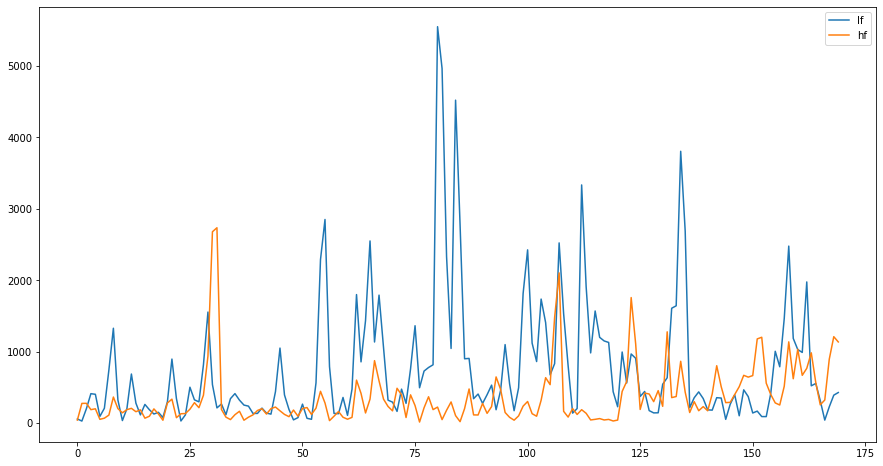

In [19]:
frequency_df[['lf', 'hf']].plot(legend=True, figsize=(15, 8))


<AxesSubplot:>

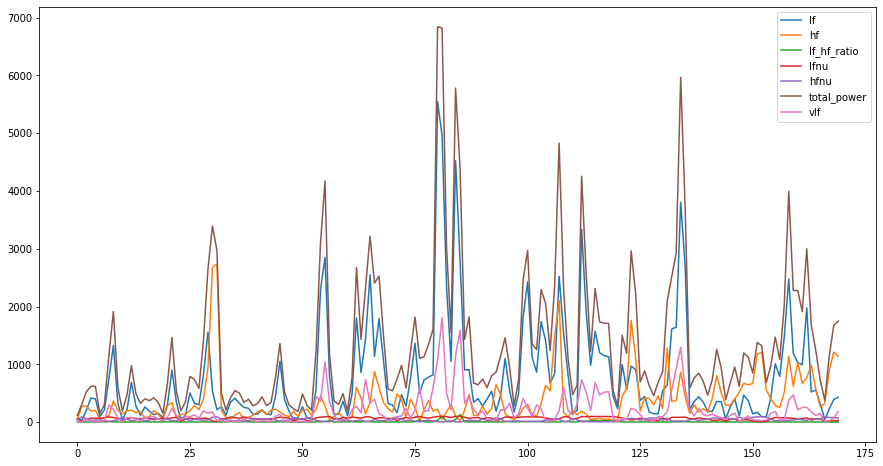

In [20]:
frequency_df.plot(legend=True, figsize=(15, 8))